In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from astropy.time import Time
import warnings
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

In [3]:
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'b': '#1f77b4',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3',
    'darkgrey': '0.2',
    'palegrey': '0.6'
}

In [4]:
print('NumPy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

NumPy version: 1.23.1
pandas version: 1.4.3
matplotlib version: 3.5.1


In [5]:
#%matplotlib notebook

In [6]:
# SN metadata

z = 0.02736
t_max_mjd = 59723.65 - 0.51 * (1 + z) # B band
ebv = 0.04
rv = 3.1

# tfl = 58972.46296299994

In [7]:
def plot_box_spec(wave, flux):
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave) / 2
    wv_plot = np.append(
        wave[0] - (wave[1] - wave[0]) / 2,
        np.append(np.repeat(wv_plot[0:-1], 2),
                  wave[-1] + (wave[-1] - wave[-2]) / 2))

    return wv_plot, flux_plot

In [8]:
spec_files = sorted(glob.glob('./data/ZTF22*'))
spec_files

['./data/ZTF22aajijjf_20220511_FTN_FLOYDS-N_Global_SN_Project.ascii',
 './data/ZTF22aajijjf_20220526_SEDM_1.txt',
 './data/ZTF22aajijjf_20220526_SEDM_2.txt',
 './data/ZTF22aajijjf_20220601_NOT_ALFOSC.ascii',
 './data/ZTF22aajijjf_20220614_SPRAT.txt',
 './data/ZTF22aajijjf_20220614_TSPEC.txt',
 './data/ZTF22aajijjf_20220623_LCO-FLOYDS.ascii',
 './data/ZTF22aajijjf_20220629_LRIS.ascii',
 './data/ZTF22aajijjf_20220629_SPRAT.txt',
 './data/ZTF22aajijjf_20220724_NOT_ALFOSC.ascii',
 './data/ZTF22aajijjf_20230314_Binospec-bin.ascii',
 './data/ZTF22aajijjf_20230314_Binospec.ascii',
 './data/ZTF22aajijjf_20230426_LRIS.ascii']

In [9]:
# SN metadata


class SN_meta:
    def __init__(self, name, z, tmax, ebv, files, IR_thres=1.1e4):
        self.name = name
        self.z = z
        self.t_max_mjd = tmax
        self.ebv = ebv
        files = np.sort(files)
        files = files[[i for i in range(len(files)) if not ('tell' in files[i])]]
        self.NIRfiles = files[[(np.loadtxt(spec)[-1, 0] > IR_thres)
                               for spec in files]]
        self.NIRfiles = self.NIRfiles[[
            not ('GNIRS_v' in spec) for spec in self.NIRfiles
        ]]
        self.OPTfiles = files[[(np.loadtxt(spec)[-1, 0] < IR_thres)
                               for spec in files]]
        print(self.NIRfiles)


joj = SN_meta('SN\ 2022joj',
              z=0.02736,
              tmax=t_max_mjd,
              ebv=0.04,
              files=glob.glob('./data/ZTF22*'))

['./data/ZTF22aajijjf_20220614_TSPEC.txt']


In [10]:
import astropy.units as u
from spec_to_flux import spec_to_flux, spec_to_mag
flts = sorted(glob.glob('../photometry/filters/*'))
flts

['../photometry/filters/P48_I.dat',
 '../photometry/filters/P48_R.dat',
 '../photometry/filters/P48_g.dat']

## Spectral sequence

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_22548/2714530249.py:28: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_22548/2714530249.py:28: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_22548/2714530249.py:28: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


$\mathrm{FLOYDS}$ -12.495748372671212
$\mathrm{SEDM}$ 2.1584940042729044
$\mathrm{SEDM}$ 2.2414855552934965
$\mathrm{ALFOSC}$ 8.658039635567988
$\mathrm{SPRAT}$ 21.25085812178787
$\mathrm{FLOYDS}$ 28.589045904067316
$\mathrm{LRIS}$ 36.255789207287165
$\mathrm{SPRAT}$ 35.818233725277906
$\mathrm{ALFOSC}$ 60.119494237657044
$\mathrm{Binospec}$ 286.45861586979964
$\mathrm{LRIS}$ 329.420478313346


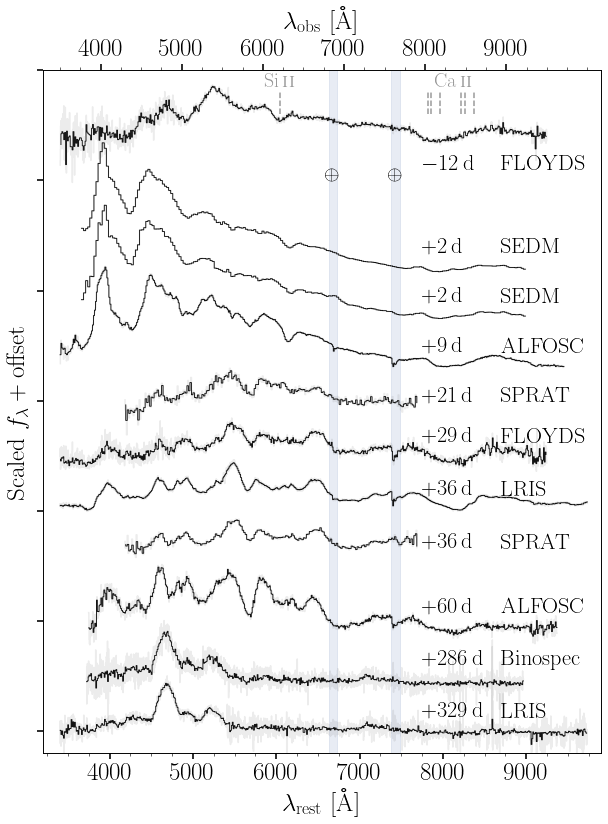

In [34]:
fig, ax = plt.subplots(figsize=(9, 12))
spec_num = 0
for spec in spec_files:
    if 'cal' in spec: continue
    if ('TSPEC' in spec) or ('bin' in spec):
        continue
    elif 'SEDM' in spec:
        instru = 'SEDM'
    elif 'SPRAT' in spec:
        instru = 'SPRAT'
    elif 'NOT' in spec:
        instru = 'ALFOSC'
    elif 'FLOYDS' in spec:
        instru = 'FLOYDS'
    elif 'Binospec' in spec:
        instru = 'Binospec'
    elif 'LRIS' in spec:
        instru = "LRIS"
    instru = '$\mathrm{' + instru + '}$'
    spec_df = pd.read_csv(spec,
                          comment='#',
                          delim_whitespace=True,
                          header=None)

    try:
        fl_unc = spec_df[2].values
    except:
        warnings.warn("No flux uncertainty in the datafile!")
        # set relative uncertainty to be 10%
        fl_unc = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
            spec_df[0].values)
    with open(spec) as f:
        ll = f.readlines()
    # brute force
    mjd_found = False
    for l in ll:
        if 'MJD_OBS' in l:
            mjd_obs = float(l.split(':')[1])
        elif 'MJD' in l:
            mjd_obs = float(l.split('=')[1].split('/')[0])

    phase = (mjd_obs - t_max_mjd) / (1 + z)
    print(instru, phase)
    # if ((phase > 100) and (not 'sub' in spec)):
    #     print(spec)
    #     continue
    spec_num += 1
    if mjd_obs < t_max_mjd:
        if mjd_obs < t_max_mjd:
            ax.text(7750, 6.5-5.5 * spec_num,
                    r'$-{:.0f}\,\mathrm d$'.format(np.abs(phase)), fontsize=22.5)
        else:
            ax.text(7750, 6.5-5.5 * spec_num,
                    r'$+{:.0f}\,\mathrm d$'.format(np.abs(phase)), fontsize=22.5)
        ax.text(8700, 6.5-5.5 * spec_num, instru, fontsize=22.5)
    elif mjd_obs < t_max_mjd + 25:
        ax.text(7750, 2.4 - 4.5 * spec_num,
                r'$+{:.0f}\,\mathrm d$'.format(np.abs(phase)), fontsize=22.5)
        ax.text(8700, 2.4 - 4.5 * spec_num, instru, fontsize=22.5)
    elif mjd_obs < t_max_mjd + 50:
        ax.text(7750, 5 - 4.8 * spec_num,
                r'$+{:.0f}\,\mathrm d$'.format(np.abs(phase)), fontsize=22.5)
        ax.text(8700, 5 - 4.8 * spec_num, instru, fontsize=22.5)
    else:
        ax.text(7750, 3.5 - 4.75 * spec_num,
                r'$+{:.0f}\,\mathrm d$'.format(np.abs(phase)), fontsize=22.5)
        ax.text(8700, 3.5 - 4.75 * spec_num, instru, fontsize=22.5)

    fl_unc0 = fl_unc.copy()

    out = data_binning(np.array([spec_df[0].values, spec_df[1].values,
                                 fl_unc]).T,
                       size=10)

    wv, fl = plot_box_spec(out[:, 0], out[:, 1])
    wv0, fl0 = plot_box_spec(spec_df[0].values, spec_df[1].values)

    fl_unc = np.repeat(out[:, -1], 2)
    fl_unc0 = np.repeat(fl_unc0, 2)

    if 'SPRAT' in instru:
        snr = 1
        bl, rd = 4300, 7900
    elif 'FLOYDS' in instru:
        snr = 1
        bl, rd = 3500, 9500
    else:
        snr = 2
        bl, rd = 3500, 10000
    # try:
    #     wv_cut0 = out[np.where(~((out[:, 0] >= bl)
    #                              | (out[:, 1] >= out[:, 2] * snr)))[0][-1], 0]
    # except IndexError:
    #     wv_cut0 = bl
    wv_cut0 = bl
    fl = fl[wv > wv_cut0]
    fl_unc = fl_unc[wv > wv_cut0]
    wv = wv[wv > wv_cut0]
    # try:
    #     wv_cut1 = out[np.where(~((out[:, 0] <= rd)
    #                              | (out[:, 1] >= out[:, 2] * snr)))[0][0], 0]
    # except IndexError:
    #     wv_cut1 = rd
    wv_cut1 = rd
    fl = fl[wv < wv_cut1]
    fl_unc = fl_unc[wv < wv_cut1]
    wv = wv[wv < wv_cut1]
    
    E = 10**(0.4 * calALambda(wv, rv, ebv))
    E0 = 10**(0.4 * calALambda(wv0, rv, ebv))
    fl *= E
    if phase > 100:
        norm_flux = np.nanmax(fl[np.where((wv > 4600) & (wv < 4800))]) / 5
    elif np.abs(phase) < 5:
        norm_flux = np.nanmedian(fl[np.where((wv > 7300) & (wv < 7500))]) / 1.5
    else:
        norm_flux = np.nanmedian(fl[np.where((wv > 7300) & (wv < 7500))]) / 1.7
    if phase < 0:
        ax.plot(wv / (1 + z),
                fl / norm_flux - 4.2 * spec_num + 7.5,
                color='k',
                linewidth=0.9)
        ax.plot(
            wv0[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / (1 + z),
            (fl0 * E0)[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / norm_flux - 4.2 * spec_num + 7.5,
            color='grey',  # aam_colors['blue'],
            alpha=0.15)
    elif phase < 50:
        ax.plot(wv / (1 + z),
                fl / norm_flux - 4.25 * spec_num - 0.5,
                color='k',
                linewidth=0.9)
        ax.plot(
            wv0[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / (1 + z),
            (fl0 * E0)[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / norm_flux - 4.25 * spec_num - 0.5,
            color='grey',  # aam_colors['blue'],
            alpha=0.15)
    else:
        ax.plot(wv / (1 + z),
                fl / norm_flux - 4.65 * spec_num + 0.5,
                color='k',
                linewidth=0.9)
        ax.plot(
            wv0[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / (1 + z),
            (fl0 * E0)[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / norm_flux - 4.65 * spec_num + 0.5,
            color='grey',  # aam_colors['blue'],
            alpha=0.15)
    

ax.text(7633 / (1 + z), .0, r'$\oplus$', ha='center', fontsize=20)
ax.text(6867 / (1 + z), .0, r'$\oplus$', ha='center', fontsize=20)

ax.fill_between([7633 / (1 + z) - 50, 7633 / (1 + z) + 50], [-60, -60],
                [30, 30],
                color=color_map['blue'],
                alpha=0.2)
ax.fill_between([6867 / (1 + z) - 50, 6867 / (1 + z) + 50], [-60, -60],
                [30, 30],
                color=color_map['blue'],
                alpha=0.2)
# Ca ii and Si ii lines
C = 299792.458
def dlam_lam(v): return ((1 - v / C) / (1 + v / C))**.5


param_dic = {'linestyle': '--', 'color': '0.6', 'zorder': -10}
ax.text(s=r'$\mathrm{Si}\,\textsc{ii}$',
        x=6355 * dlam_lam(15000),
        y=8.5,
        fontsize=20,
        color='0.6',
        ha='center')
ax.plot([6355 * dlam_lam(15000), 6355 * dlam_lam(15000)], [6, 8],
        **param_dic)
ax.text(s=r'$\mathrm{Ca}\,\textsc{ii}$',
        x=8542 * dlam_lam(15000),
        y=8.5,
        fontsize=20,
        color='0.6',
        ha='center')
ax.plot([8498 * dlam_lam(25000), 8498 * dlam_lam(25000)], [6, 8],
        **param_dic)
ax.plot([8542 * dlam_lam(25000), 8542 * dlam_lam(25000)], [6, 8],
        **param_dic)
ax.plot([8662 * dlam_lam(25000), 8662 * dlam_lam(25000)], [6, 8],
        **param_dic)
ax.plot([8498 * dlam_lam(10000), 8498 * dlam_lam(10000)], [6, 8],
        **param_dic)
ax.plot([8542 * dlam_lam(10000), 8542 * dlam_lam(10000)], [6, 8],
        **param_dic)
ax.plot([8662 * dlam_lam(10000), 8662 * dlam_lam(10000)], [6, 8],
        **param_dic)

ax.set_xlim(3200, 9900)
ax.set_yticklabels([])
ax.set_ylabel(r'$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$')
ax.set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$')
ax.xaxis.set_minor_locator(MultipleLocator(250))
# ax.yaxis.set_major_locator(MultipleLocator(1))

# ax[1].set_xlim(3450, 9600)
ax.set_ylim(-52, 10)
ax.set_xticks(np.arange(4, 10) * 1000)
# ax[1].set_xticks(np.arange(4, 10) * 1000)
# ax[1].set_ylim(-h * (num + .5), h * 1.5)
# ax[1].set_yticklabels([])
# ax[1].set_ylabel('')
# ax[1].set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$',
#                  **{'fontname': 'Times New Roman'})
# ax[1].xaxis.set_minor_locator(MultipleLocator(250))

# ax[1].text(7633 / (1 + z) + 5, -0.52, r'$\oplus$', ha='center', fontsize=20)
# ax[1].text(6867 / (1 + z) + 40, -0.27, r'$\oplus$', ha='center', fontsize=20)
# ax[1].yaxis.set_major_locator(MultipleLocator(1))

#fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
#fig.savefig('../paper/figures/NIR_spec_comp.pdf', bbox_inches='tight')

wv_obs = ax.twiny()
wv_obs.set_xlim(np.array(ax.get_xlim()) * (1 + z))
wv_obs.set_xticks(np.arange(4, 10) * 1000)
wv_obs.set_xlabel(r'$\lambda_\mathrm{obs}\ [\mathrm{\r{A}}]$', labelpad=10)
wv_obs.xaxis.set_minor_locator(MultipleLocator(250))

fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
fig.tight_layout()


## Spectra comparison

### Peak

In [23]:
by = np.loadtxt('./SN1999by/SN1999by_1999-05-08_03-36-00_FLWO-1.5m_FAST_CfA-Ia.flm')
aa = np.loadtxt('./SN1999aa/SN1999aa_1999-02-23_05-41-17_Lick-3m_KAST_BSNIP.flm')
T = np.loadtxt('./SN1991T/SN1991T_1991-05-05_00-00-00_Lick-3m_UV-Schmidt_UCB-SNDB.flm')
cx = np.loadtxt('./SN2000cx/SN2000cx_2000-07-28_09-30-14_Lick-3m_KAST_UCB-SNDB.flm')
joj = np.loadtxt('./data/ZTF22aajijjf_20220526_SEDM_1.txt')
joj[:, 1] = joj[:, 1] * 10**(0.4 * calALambda(joj[:, 0], EBV=ebv, RV=rv))

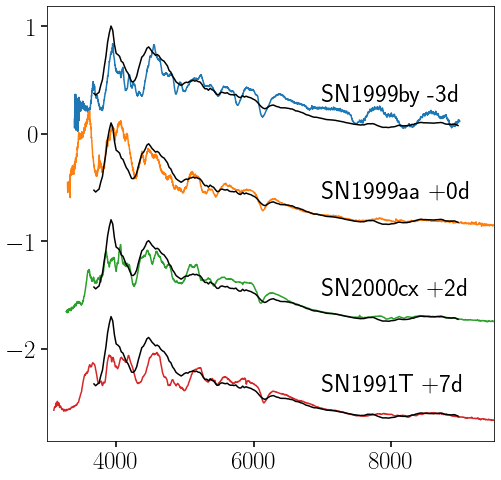

In [24]:
plt.figure(figsize=(8, 8))
# Not corrected for MW extinction!
plt.plot(by[:, 0]/(1 + 0.002128), by[:, 1]/np.max(by[:, 1] * 1.2))
plt.text(s='SN1999by -3d', x=7000, y=0.3)
plt.plot(aa[:, 0]/(1 + 0.014907), aa[:, 1]/np.max(aa[:, 1] * 0.9) - 0.9)
plt.text(s='SN1999aa +0d', x=7000, y=0.3 - 0.9)
plt.plot(cx[:, 0]/(1 + 0.00802), cx[:, 1]/np.max(cx[:, 1] * 1.3) - 0.9 * 2)
plt.text(s='SN2000cx +2d', x=7000, y=0.3 - 0.9 * 2)
plt.plot(T[:, 0]/(1 + 0.005777), T[:, 1]/np.max(T[:, 1] * 1.5) - 0.9 * 3)
plt.text(s='SN1991T +7d', x=7000, y=0.3 - 0.9 * 3)

plt.xlim(3000, 9500)

for k in range(4):
    plt.plot(joj[:, 0]/(1+z), joj[:, 1]/np.max(joj[:, 1]) - 0.9 * k, color='k')

### Transitional

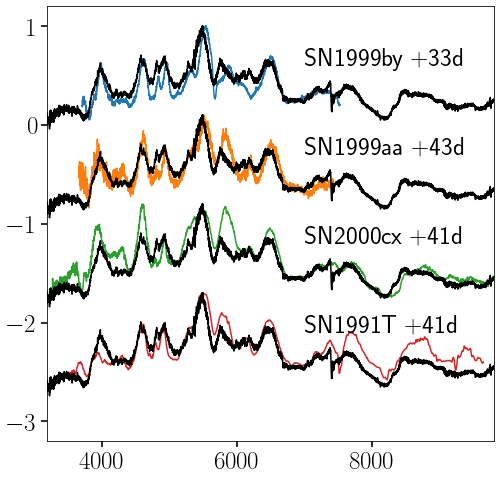

In [33]:
by = np.loadtxt('./SN1999by/SN1999by_1999-06-13_03-50-24_FLWO-1.5m_FAST_CfA-Ia.flm')
aa = np.loadtxt('./SN1999aa/SN1999aa_1999-04-07_03-36-00_FLWO-1.5m_FAST_CfA-Ia.flm')
T = np.loadtxt('./SN1991T/SN1991T_1991-06-08_WHT-4.2m_FOS-2_SUSPECT.dat')
cx = np.loadtxt('./SN2000cx/SN2000cx_2000-09-06_10-10-34_Lick-3m_KAST_UCB-SNDB.flm')
joj = np.loadtxt('./data/ZTF22aajijjf_20220629_LRIS.ascii')
joj[:, 1] = joj[:, 1] * 10**(0.4 * calALambda(joj[:, 0], EBV=ebv, RV=rv))

plt.figure(figsize=(8, 8))
# Not corrected for MW extinction!
h = 0.6
plt.plot(by[:, 0]/(1 + 0.002128), by[:, 1]/np.max(by[:, 1]))
plt.text(s='SN1999by +33d', x=7000, y=h)
plt.plot(aa[:, 0]/(1 + 0.014907), aa[:, 1]/np.max(aa[:, 1]) - 0.9)
plt.text(s='SN1999aa +43d', x=7000, y=h - 0.9)
plt.plot(cx[:, 0]/(1 + 0.00802), cx[:, 1]/np.max(cx[:, 1]) - 0.9 * 2)
plt.text(s='SN2000cx +41d', x=7000, y=h - 0.9 * 2)
plt.plot(T[:, 0]/(1 + 0.005777), T[:, 1]/np.max(T[:, 1]) - 0.9 * 3)
plt.text(s='SN1991T +41d', x=7000, y=h - 0.9 * 3)

plt.xlim(3200, 9800)
plt.ylim(-3.2, 1.2)

for k in range(4):
    plt.plot(joj[:, 0]/(1+z), joj[:, 1]/np.max(joj[:, 1]) - 0.9 * k, color='k')